# Micro-contributions and active editors

We're interested in understanding to what extent users who make micro-contributions are also active editors, and to what extent these users are classified as "new active editors" (meaning their account on the wiki was created in the same month).

We currently have three types of micro-contributions:

1. Description edits on Wikidata.
2. Caption edits on Commons.
3. Depicts edits on Commons.

So, for Wikidata and Commons, we would like to know how many active editors those wikis had over time, how many of them were making micro-contributions, how many of them made enough micro-contributions to qualify as an active editor, and lastly how many of the latter two groups of where new accounts in a given month.

## Next up

Micro-contributions impact on the number of active editors:

1. DONE! What would the number of active editors be if we took out micro-contributions?
2. DONE! What is the number of active editors who *only* made micro-contributions?

Next up, I'll reach out to Connie and Maya to get some extra eyes on this to make sure my methodology is sane.

The impact of Wiki Loves Earth and Wiki Loves Pride:

1. DONE! What is the number of active editors if we remove all WLE/WLP activity?
2. DONE! What is the number of active editors who uploaded WLE/WLP contributions?

We're interested in understanding the impact of WLE/WLP for users who uploaded files as part of the campaigns.

In [1]:
import pandas as pd
import numpy as np

from wmfdata import hive

You can find the source for `wmfdata` at https://github.com/neilpquinn/wmfdata


In [61]:
## Load the RPython library so we can use R for graphs

%load_ext rpy2.ipython

In [62]:
%%R
library(ggplot2)
library(data.table)

First, let's grab user IDs of all users who are labelled as active editors in a given month for the given wikis and date ranges associated with those wikis. Because we want something to compare with, we'll grab data for a year prior to the micro-contributions being released.

In [12]:
## based on
## from https://github.com/wikimedia-research/Editing-movement-metrics/blob/master/queries/active_editors.sql
active_editors_query = '''
WITH active_editors AS (
  SELECT
    CAST(month AS date) AS log_month,
    user_id,
    user_name,
    SUM(content_edits) AS content_edits,
    MAX(bot_by_group) AS bot_by_group,
    CAST(TRUNC(MIN(user_registration), "MONTH") AS date) AS registration_month
  FROM neilpquinn.editor_month
  WHERE
    wiki = "{wiki}"
    AND month BETWEEN "{start_ts}" AND "{end_ts}"
    AND user_id != 0
  GROUP BY month, user_id, user_name
)
FROM active_editors
SELECT log_month, user_id, content_edits, 
       CAST(registration_month = log_month AS int) AS is_new_active
WHERE
  content_edits >= 5
  AND NOT bot_by_group
  AND user_name NOT REGEXP "bot\\b"
'''

In [13]:
wikidata_actives = hive.run([
    "SET mapreduce.map.memory.mb=4096",    
    active_editors_query.format(
        snapshot = "2019-07",
        wiki = "wikidatawiki",
        start_ts = "2016-01-01",
        end_ts = "2019-08-01")
])

In [14]:
commons_actives = hive.run([
    "SET mapreduce.map.memory.mb=4096",    
    active_editors_query.format(
        snapshot = "2019-07",
        wiki = "commonswiki",
        start_ts = "2018-01-01",
        end_ts = "2019-08-01")
])

Next, we grab similar data (user ID, month, number of edits) for all micro-contributions made to the given wikis.

In [32]:
## we won't have to worry about distinguishing between bots and regular users in this case,
## because we'll filter those out when we join with the previous datasets.
wd_mce_query = '''
SELECT DATE_FORMAT(event_timestamp, "yyyy-MM-01") AS log_month, event_user_id, count(*) AS num_micros
FROM wmf.mediawiki_history
WHERE snapshot = "{snapshot}"
  AND wiki_db = "wikidatawiki"
  AND event_timestamp >= "{start_ts}"
  AND event_timestamp < "{end_ts}"
  AND event_entity = "revision"
  AND event_type = "create"
  AND array_contains(revision_tags, "mobile app edit") = TRUE
GROUP BY DATE_FORMAT(event_timestamp, "yyyy-MM-01"), event_user_id
'''

In [33]:
## similar query for commons
commons_mce_query = '''
SELECT DATE_FORMAT(event_timestamp, "yyyy-MM-01") AS log_month, event_user_id, count(*) AS num_micros
FROM wmf.mediawiki_history
WHERE snapshot = "{snapshot}"
  AND wiki_db = "commonswiki"
  AND event_timestamp >= "{start_ts}"
  AND event_timestamp < "{end_ts}"
  AND event_entity = "revision"
  AND event_type = "create"
  AND (
    event_comment REGEXP "^...wbsetlabel-(add|set|remove):"
    OR event_comment REGEXP "^...wbsetclaim-(create|update).*?Special:EntityPage/P180"
  )
GROUP BY DATE_FORMAT(event_timestamp, "yyyy-MM-01"), event_user_id
'''

In [34]:
wikidata_mces = hive.run([
    "SET mapreduce.map.memory.mb=4096",    
    wd_mce_query.format(
        snapshot = "2019-07",
        start_ts = "2016-01-01",
        end_ts = "2019-08-01")
])

In [35]:
commons_mces = hive.run([
    "SET mapreduce.map.memory.mb=4096",    
    commons_mce_query.format(
        snapshot = "2019-07",
        start_ts = "2016-01-01",
        end_ts = "2019-08-01")
])

In [ ]:
wikidata_mces.head()

Now, let's join the two datasets (using a left join), fill all missing data with zeroes, and start making some graphs.

In [184]:
wd_actives_full = wikidata_actives.merge(wikidata_mces,
                                         how = 'left', left_on = ['log_month', 'user_id'],
                                         right_on = ['log_month', 'event_user_id']).fillna(0)

In [185]:
commons_actives_full = commons_actives.merge(commons_mces,
                                             how = 'left', left_on = ['log_month', 'user_id'],
                                             right_on = ['log_month', 'event_user_id']).fillna(0)

In [186]:
## turn log month into dates

wd_actives_full['log_month'] = pd.to_datetime(wd_actives_full['log_month'])
commons_actives_full['log_month'] = pd.to_datetime(commons_actives_full['log_month'])

In [187]:
## Calculate the number of content contributions with micro-contributions removed

wd_actives_full['non_micro_edits'] = wd_actives_full.content_edits - wd_actives_full.num_micros
commons_actives_full['non_micro_edits'] = commons_actives_full.content_edits - commons_actives_full.num_micros

In [85]:
def get_active_stats(df, start_date, end_date):
    '''
    For the given `pandas.DataFrame` `df` containing information on number of content edits,
    account age status (new or existing user), and number of micro-contribution edits made,
    calculate for each month between `start_date` and `end_date` the following stats:
    
    * Number of active editors (all users in that month, our dataset only includes active editors)
    * Number of active editors who made at least 1 micro-contribution
    * Number of active editors who made 5 or more micro-contributions (meaning they made enough
      to quality as an active editor by micro-contributions alone)
    * Number of active editors who made at least 1 micro-contribution who were new that month
    * Number of active editors who made 5 or more micr-contributions who were new that month.
    '''

    ## Date range from start to end:
    date_range = pd.date_range(start_date, end_date, freq = "MS")

    ## Long-form data frame with month, type of editor (active, active w/1+ mce, etc), and number of editors
    res_df = pd.DataFrame(columns = ['log_month', 'editor_type', 'n'])
    
    for month_idx in range(len(date_range) -1): ## iterate but exclude the last month
        ## All users are active because we filtered out non-active ones
        n_active = len(df.loc[(df.log_month >= date_range[month_idx]) &
                              (df.log_month < date_range[month_idx + 1])])
        
        res_df = res_df.append(
                pd.DataFrame([[date_range[month_idx], 'active', n_active]],
                             columns = ['log_month', 'editor_type', 'n']
                )
            )
        
        ## Actives who made at least one micro-contribution
        n_mces = len(df.loc[(df.log_month >= date_range[month_idx]) &
                              (df.log_month < date_range[month_idx + 1]) &
                              (df.num_micros > 0)])

        res_df = res_df.append(
                pd.DataFrame([[date_range[month_idx], '1+ micro', n_mces]],
                             columns = ['log_month', 'editor_type', 'n']
                )
            )
        
        ## Actives who made at least five micro-contributions
        n_active_mces = len(df.loc[(df.log_month >= date_range[month_idx]) &
                                   (df.log_month < date_range[month_idx + 1]) &
                                   (df.num_micros >= 5)])

        res_df = res_df.append(
                pd.DataFrame([[date_range[month_idx], '5+ micro', n_active_mces]],
                             columns = ['log_month', 'editor_type', 'n']
                )
            )
        
        ## New active editors
        n_new_active = len(df.loc[(df.log_month >= date_range[month_idx]) &
                                  (df.log_month < date_range[month_idx + 1]) &
                                  (df.is_new_active == 1)])

        res_df = res_df.append(
                pd.DataFrame([[date_range[month_idx], 'new active', n_new_active]],
                             columns = ['log_month', 'editor_type', 'n']
                )
            )
        
        ## New active editors w/1+ micro-contributions
        n_new_mces = len(df.loc[(df.log_month >= date_range[month_idx]) &
                                (df.log_month < date_range[month_idx + 1]) &
                                (df.is_new_active == 1) &
                                (df.num_micros > 0)])

        res_df = res_df.append(
                pd.DataFrame([[date_range[month_idx], 'new 1+ micro', n_new_mces]],
                             columns = ['log_month', 'editor_type', 'n']
                )
            )
        
        ## New active editors w/5+ micro-contributions
        n_new_active_mces = len(df.loc[(df.log_month >= date_range[month_idx]) &
                                       (df.log_month < date_range[month_idx + 1]) &
                                       (df.is_new_active == 1) &
                                       (df.num_micros >= 5)])

        res_df = res_df.append(
                pd.DataFrame([[date_range[month_idx], 'new 5+ micro', n_new_active_mces]],
                             columns = ['log_month', 'editor_type', 'n']
                )
            )
        
    return(res_df)    

In [97]:
def get_corrected_stats(df, start_date, end_date):
    '''
    For the given `pandas.DataFrame` `df` containing information on number of content edits,
    account age status (new or existing user), and number of micro-contribution edits made,
    calculate for each month between `start_date` and `end_date` the following stats:
    
    * Number of active editors with micro-contributions removed
    * Number of active editors who only made micro-contributions
    * Number of new active editors with micro-contributions removed
    * Number of new active editors who only made micro-contributions
    '''

    ## Date range from start to end:
    date_range = pd.date_range(start_date, end_date, freq = "MS")

    ## Long-form data frame with month, type of editor (active, active w/1+ mce, etc), and number of editors
    res_df = pd.DataFrame(columns = ['log_month', 'editor_type', 'n'])
    
    for month_idx in range(len(date_range) -1): ## iterate but exclude the last month
        ## Number of active editors with micro-contributions removed
        n_active_wo_mces = len(df.loc[(df.log_month >= date_range[month_idx]) &
                                       (df.log_month < date_range[month_idx + 1]) &
                                       (df.non_micro_edits >= 5)])
        
        res_df = res_df.append(
                pd.DataFrame([[date_range[month_idx], 'active w/o micro', n_active_wo_mces]],
                             columns = ['log_month', 'editor_type', 'n']
                )
            )
        
        ## Number of active editors who only made micro-contributions
        n_active_only_mces = len(df.loc[(df.log_month >= date_range[month_idx]) &
                                        (df.log_month < date_range[month_idx + 1]) &
                                        (df.content_edits == df.num_micros)])
        
        res_df = res_df.append(
                pd.DataFrame([[date_range[month_idx], 'active only micro', n_active_only_mces]],
                             columns = ['log_month', 'editor_type', 'n']
                )
            )
        
        ## Number of new active editors with micro-contributions removed
        n_new_active_wo_mces = len(df.loc[(df.log_month >= date_range[month_idx]) &
                                       (df.log_month < date_range[month_idx + 1]) &
                                       (df.is_new_active == 1) &
                                       (df.non_micro_edits >= 5)])
        
        res_df = res_df.append(
                pd.DataFrame([[date_range[month_idx], 'new active w/o micro', n_new_active_wo_mces]],
                             columns = ['log_month', 'editor_type', 'n']
                )
            )
    
        ##Number of new active editors who only made micro-contributions
        n_active_only_mces = len(df.loc[(df.log_month >= date_range[month_idx]) &
                                        (df.log_month < date_range[month_idx + 1]) &
                                        (df.is_new_active == 1) &
                                        (df.content_edits == df.num_micros)])
        
        res_df = res_df.append(
                pd.DataFrame([[date_range[month_idx], 'new active only micro', n_active_only_mces]],
                             columns = ['log_month', 'editor_type', 'n']
                )
            )
    return(res_df)    

In [87]:
wd_active_stats = get_active_stats(wd_actives_full, '2016-01-01', '2019-07-01')

In [88]:
commons_active_stats = get_active_stats(commons_actives_full, '2018-01-01', '2019-07-01')

In [98]:
wd_corrected_stats = get_corrected_stats(wd_actives_full, '2016-01-01', '2019-07-01')

In [99]:
commons_corrected_stats = get_corrected_stats(commons_actives_full, '2018-01-01', '2019-07-01')

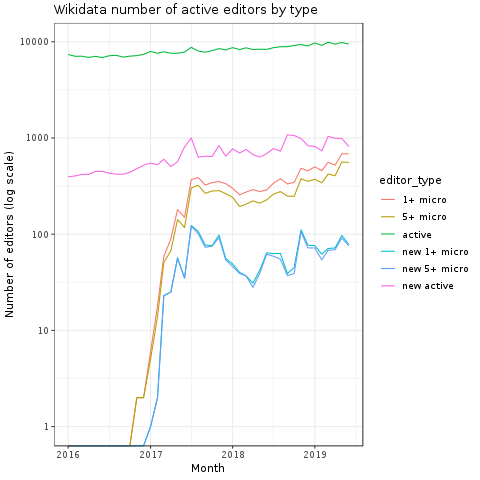

In [128]:
%%R -i wd_active_stats

wd_active_stats$log_month = as.Date(wd_active_stats$log_month)

ggplot(wd_active_stats,
       aes(x = log_month, y = n, color = editor_type)) +
theme_bw() +
scale_y_log10("Number of editors (log scale)") +
scale_x_date("Month") +
ggtitle("Wikidata number of active editors by type") +
geom_line()

What does this graph tell us? Overall, we see that the number of active editors on Wikidata is fairly stable, but slowly increasing over time, reaching around 10k in more recent months. We can also see that there is a slowly increasing trend in the number of new active editors on Wikidata, and that it passed 1k in both the end of 2018 and early 2019.

What we can also see is that the number of new active editors who made microcontributions is not large, it generally ends up being about 100. Those who do make microcontributions tend to make enough of those alone to become an active editor. We can also see that it is not clear that the trend is an increase in these editors.

Lastly, we see that there an increase in the number of active editors over time who make micro-contributions. Because we don't see an increase in the trend of new editors, this means that these are users who have been around. I think this motivates looking into whether users who make micro-contributions are more likely to be retained.

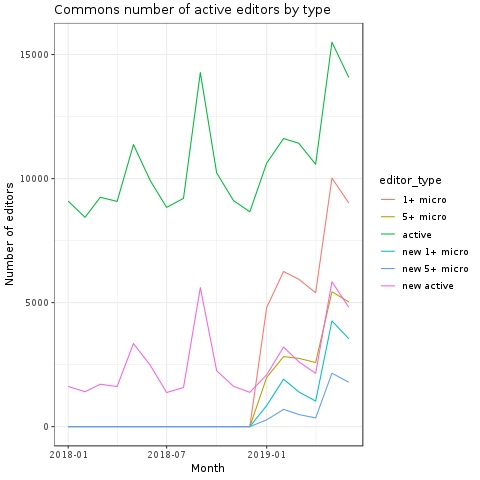

In [129]:
%%R -i commons_active_stats

commons_active_stats$log_month = as.Date(commons_active_stats$log_month)

ggplot(commons_active_stats,
       aes(x = log_month, y = n, color = editor_type)) +
theme_bw() +
scale_y_continuous("Number of editors") +
scale_x_date("Month") +
ggtitle("Commons number of active editors by type") +
geom_line()

What does this graph tell us? First, we can see the overall trends of increases in May/June (Wiki Loves Earth) and September (Wiki Loves Monuments) that we expect, the former for both 2018 and 2019. We can also see that these increases correlate with increases in new active editors, meaning that we see a fair amount of new users coming to Commons that make at least 5 edits.

Secondly, we see the introduction of micro-contributions in January of this year. We see that about half of the active editors make a micro-contribution in January through April, while in May and June the proportion is about two thirds. Similarly, we see new editors also come in and contribute to these numbers. Quite a number of them make at least one micro-contribution, and many of them make at least five.

In [ ]:
## Looking at the numbers to get a sense of proportions:
commons_active_stats.loc[commons_active_stats.log_month >= '2019-01-01']

Let's get a sense of how the number of active contributors is affected by micro-contributions by taking them out, and also looking at number of active editors who only made micro-contributions.

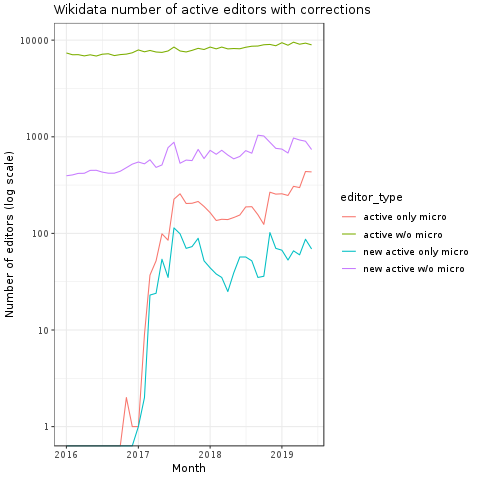

In [130]:
%%R -i wd_corrected_stats

wd_corrected_stats$log_month = as.Date(wd_corrected_stats$log_month)

ggplot(wd_corrected_stats,
       aes(x = log_month, y = n, color = editor_type)) +
theme_bw() +
scale_y_log10("Number of editors (log scale)") +
scale_x_date("Month") +
ggtitle("Wikidata number of active editors with corrections") +
geom_line()

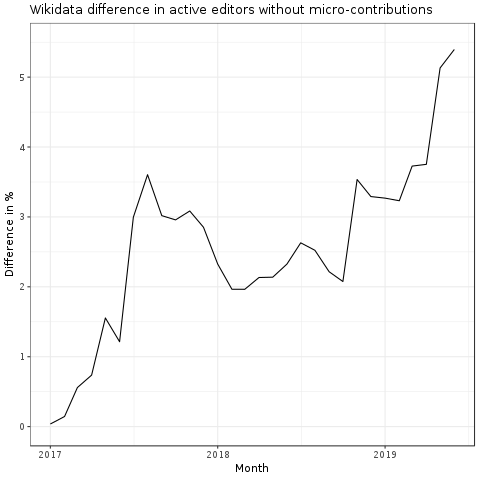

In [131]:
%%R -i wd_active_stats,wd_corrected_stats

## Merge the two and calculate a diff between active with and without micro-contributions

wd_active_stats = data.table(wd_active_stats)
wd_corrected_stats = data.table(wd_corrected_stats)

wd_both = merge(wd_active_stats[editor_type == 'active', list(log_month, n_active = n)],
                wd_corrected_stats[editor_type == 'active w/o micro', list(log_month, n_active_nomicro = n)],
                by = 'log_month')
wd_both[, n_diff := n_active - n_active_nomicro]
wd_both[, prop_diff := 100 * n_diff / n_active]
wd_both[, log_month := as.Date(log_month)]

ggplot(wd_both[log_month >= as.Date('2017-01-01')],
       aes(x = log_month, y = prop_diff)) +
theme_bw() +
scale_y_continuous("Difference in %", lim = c(0, 5.5), breaks = c(0:5)) +
scale_x_date("Month") +
ggtitle("Wikidata difference in active editors without micro-contributions") +
geom_line()

So, for Wikidata we see that the number of new active editors who solely make micro-contributions is fairly stable over time. However, we find an increasing influence of micro-contributions on the overall number of active editors, particularly in the first half of 2019. This is also seen in the other graph above, where the number of active editors who are solely making micro-contributions is increasing over time, particularly in the past six months.

Let's make the same investigation for Commons.

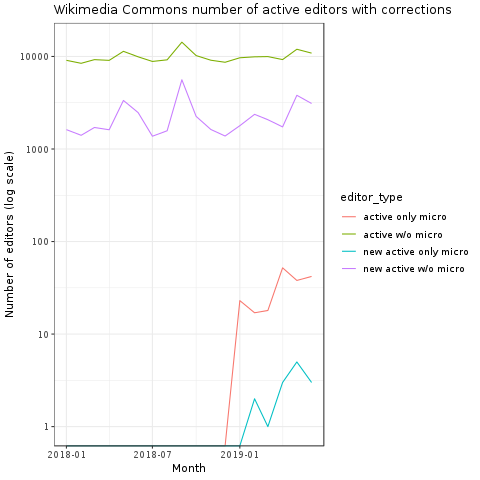

In [132]:
%%R -i commons_corrected_stats

commons_corrected_stats$log_month = as.Date(commons_corrected_stats$log_month)

ggplot(commons_corrected_stats,
       aes(x = log_month, y = n, color = editor_type)) +
theme_bw() +
scale_y_log10("Number of editors (log scale)") +
scale_x_date("Month") +
ggtitle("Wikimedia Commons number of active editors with corrections") +
geom_line()

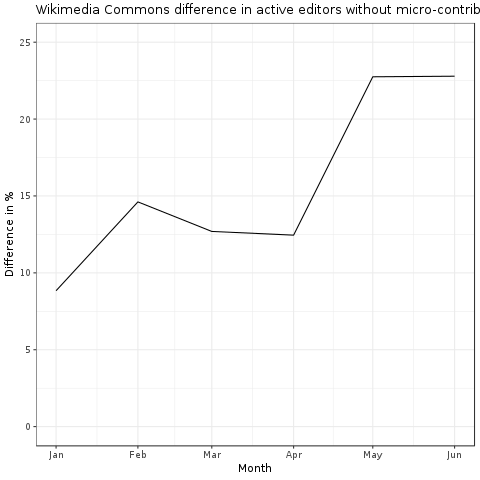

In [135]:
%%R -i commons_active_stats,commons_corrected_stats

## Merge the two and calculate a diff between active with and without micro-contributions

commons_active_stats = data.table(commons_active_stats)
commons_corrected_stats = data.table(commons_corrected_stats)

commons_both = merge(commons_active_stats[editor_type == 'active', list(log_month, n_active = n)],
                commons_corrected_stats[editor_type == 'active w/o micro', list(log_month, n_active_nomicro = n)],
                by = 'log_month')
commons_both[, n_diff := n_active - n_active_nomicro]
commons_both[, prop_diff := 100 * n_diff / n_active]
commons_both[, log_month := as.Date(log_month)]

ggplot(commons_both[log_month >= as.Date('2019-01-01')],
       aes(x = log_month, y = prop_diff)) +
theme_bw() +
scale_y_continuous("Difference in %", lim = c(0, 25)) +
scale_x_date("Month") +
ggtitle("Wikimedia Commons difference in active editors without micro-contributions") +
geom_line()

What we see on Commons are stark differences compared to what we've previously seen. First, the number of active editors when taking micro-contributions out is fairly stable, around 10,000. The increase in May/June that we've seen before and associated with Wiki Loves Earth goes away. Secondly, we see that micro-contributions are not what active users on Commons do, the number of new users who only make those contributions is very small, and the overall number is also less than 1% of the total.

The second graph tells a very different story, where we see the difference in proportions between active editors depending on whether we count micro-contributions or not. Here, we see that in May and June, the difference is 23% lower if we take those contributions out. We can also see that this proportion was lower before May and June when WLE ran, prior to that the range is 9–15%. That is still a substantial difference, but nowhere as strong as for May and June.

It's also worth noticing that the number of active editors on Wikidata and Commons is roughly comparable in some of these graphs. For example in both of the corrected ones, the number of active editors is around 10,000.

In [127]:
%%R

commons_both

     log_month n_active n_active_nomicro n_diff prop_diff
 1: 2018-01-01     9091             9091      0  0.000000
 2: 2018-02-01     8439             8439      0  0.000000
 3: 2018-03-01     9246             9246      0  0.000000
 4: 2018-04-01     9079             9079      0  0.000000
 5: 2018-05-01    11370            11370      0  0.000000
 6: 2018-06-01     9914             9914      0  0.000000
 7: 2018-07-01     8840             8840      0  0.000000
 8: 2018-08-01     9202             9202      0  0.000000
 9: 2018-09-01    14275            14275      0  0.000000
10: 2018-10-01    10230            10230      0  0.000000
11: 2018-11-01     9112             9112      0  0.000000
12: 2018-12-01     8661             8661      0  0.000000
13: 2019-01-01    10624             9685    939  8.838479
14: 2019-02-01    11613             9916   1697 14.612934
15: 2019-03-01    11424             9974   1450 12.692577
16: 2019-04-01    10577             9260   1317 12.451546
17: 2019-05-01

## Impact of WLE and WLP

The impact of Wiki Loves Earth and Wiki Loves Pride:

1. What is the number of active editors if we remove all WLE/WLP activity?
2. What is the number of active editors who uploaded WLE/WLP contributions?

To answer this, we'll use the WLE and WLP categories on Commons to identify pages within the scope of those campaigns. Because the focus of the campaigns is the multimedia content uploaded, we'll restrict the scope to the File namespace. This means that coordinating activity around these (e.g. discussions on talk pages, or updating of campaign pages) will count as "normal" edits.

For Wiki Loves Earth, we will use any files in the "Wiki Loves Earth 2019" category, as well as the category for all images named "Images from Wiki Loves Earth 2019". For Wiki Loves Pride, we'll use all images in the category "Wiki Loves Pride 2019".

As we did for micro-contributions, we'll count monthly edits by users to these files and label them as `earth_edits` and `pride_edits`. That will then allow us to take either or both out from our measurements.

To identify who uploaded this content, we'll grab the page ID of all files uploaded to commons in May and June from the Data Lake and intersect it with pages in those categories.

In [139]:
from growth import db, utils

In [228]:
db_conn = db.get_db_conn("commonswiki")

In [229]:
## monthly edits per user to files in WLE/WLP categories

## Note: don't forget to join with the actor table too, because that's where the actual user ID is.

category_count_query = '''
SELECT DATE_FORMAT(TIMESTAMP(rev_timestamp), "%Y-%m-01") AS log_month,
       actor_user AS user_id, count(*) AS {count_name}
FROM categorylinks
JOIN page
ON cl_from = page_id
JOIN revision
ON cl_from = rev_page
JOIN revision_actor_temp
ON rev_id = revactor_rev
JOIN actor
ON revactor_actor = actor_id
WHERE cl_to IN ({category_list})
AND page_namespace = 6
AND rev_timestamp >= "{start_timestamp}"
AND rev_timestamp < "{end_timestamp}"
AND actor_user > 0
GROUP BY log_month, user_id
'''

earth_categories = ["Wiki Loves Earth 2019", "Images from Wiki Loves Earth 2019"]
pride_categories = ["Wiki Loves Pride 2019"]

In [230]:
earth_counts = pd.read_sql_query(category_count_query.format(
    count_name = 'earth_edits',
    start_timestamp = dt.datetime(2019, 5, 1, 0, 0, 0).strftime(utils.mw_format),
    end_timestamp = dt.datetime(2019, 7, 1, 0, 0, 0).strftime(utils.mw_format),
    category_list = ", ".join(['"{}"'.format(c.replace(" ", "_")) for c in earth_categories])),
    db_conn
)

In [231]:
pride_counts = pd.read_sql_query(category_count_query.format(
    count_name = 'pride_edits',
    start_timestamp = dt.datetime(2019, 6, 1, 0, 0, 0).strftime(utils.mw_format),
    end_timestamp = dt.datetime(2019, 7, 1, 0, 0, 0).strftime(utils.mw_format),
    category_list = ", ".join(['"{}"'.format(c.replace(" ", "_")) for c in pride_categories])),
    db_conn
)

In [232]:
## turn log month into dates

earth_counts['log_month'] = pd.to_datetime(earth_counts['log_month'])
pride_counts['log_month'] = pd.to_datetime(pride_counts['log_month'])

In [234]:
## Merge the full Commons data with the WLE data
commons_actives_wlep = commons_actives_full.merge(earth_counts, how = "left", on = ["log_month", "user_id"]).fillna(0)

In [235]:
## Similarly, merge with the WLP data
commons_actives_wlep = commons_actives_wlep.merge(pride_counts, how = "left", on = ["log_month", "user_id"]).fillna(0)

In [152]:
## Query to get all file creations on Commons from the Data Lake, and the user who created it.
## We don't have to exclude non-registered users because they can't upload files.
## We include the month of file creation so that WLE/WLP activity can be attributed to the
## relevant month the file was uploaded.
commons_creations_query = '''
SELECT DATE_FORMAT(rev_timestamp, "yyyy-MM-01") AS log_month,
       page_id, performer.user_id
FROM event.mediawiki_page_create
WHERE year = 2019
AND month IN (5, 6)
AND `database` = "commonswiki"
AND page_namespace = 6
AND page_is_redirect = FALSE -- exclude redirects, shouldn't be part of this
'''

In [153]:
commons_creations = hive.run(commons_creations_query)

### Active editors without WLE/WLP activity

For each month in May and June, how many active editors made at least one WLE edit? And similarly, how many made at least one WLP edit? This will give us some sense of whether to include either or both in our graphs.

In [236]:
(commons_actives_wlep.loc[commons_actives_wlep.earth_edits > 0]
 .groupby("log_month")['user_id'].count().reset_index().rename(columns = {'user_id' : 'n'}))

,log_month,n
0,2019-05-01,3474
1,2019-06-01,2626


Same, but for WLP:

In [238]:
(commons_actives_wlep.loc[commons_actives_wlep.pride_edits > 0]
 .groupby("log_month")['user_id'].count().reset_index().rename(columns = {'user_id' : 'n'}))

,log_month,n
0,2019-06-01,167


Total number of active editors on Commons in May and June:

In [241]:
commons_active_stats.loc[(commons_active_stats.editor_type == 'active') &
                         ((commons_active_stats.log_month >= '2019-05-01'))]

,log_month,editor_type,n
0,2019-05-01,active,15499
0,2019-06-01,active,14078


In [242]:
## WLP proportion out of the total in June:
100 * 167 / 14078

1.186248046597528

In [243]:
## WLE proportion out of the total in May and June:

(100 * 3474 / 15499, 100 * 2626 / 14078)

(22.414349312858896, 18.653217786617418)

So, it looks like the impact of Wiki Loves Pride on the number of active editors on Commons is relatively moderate. There were 14,078 active editors on Commons in June, meaning the 167 who edited a file within the WLP campaign make up 1.2%.

Wiki Loves Earth, on the other hand, clearly has a massive influence on the number of active editors. We find that 22.4% of the May count, and 18.7% of the June count edited at least one WLE file.

Our question is what the number of active editors would be if we took at WLE/WLP activity. Because the influence of WLP is small, we disregard it for this part of the analysis, and instead only focus on WLE edits. Similarly as we did for micro-contributions, we calculate a corrected number of edits per month.

In [246]:
commons_actives_wlep['non_wle_edits'] = commons_actives_wlep.content_edits - commons_actives_wlep.earth_edits

In [256]:
def get_wle_stats(df, start_date, end_date):
    '''
    For the given `pandas.DataFrame` `df` containing information on number of content edits,
    account age status (new or existing user), and number of Wiki Loves Earth edits made,
    calculate for each month between `start_date` and `end_date` the following stats:
    
    * Number of active editors with WLE edits removed
    * Number of active editors who only made WLE edits
    * Number of new active editors with WLE edits removed
    * Number of new active editors who only made WLE edits
    '''

    ## Date range from start to end:
    date_range = pd.date_range(start_date, end_date, freq = "MS")

    ## Long-form data frame with month, type of editor (active, active w/1+ mce, etc), and number of editors
    res_df = pd.DataFrame(columns = ['log_month', 'editor_type', 'n'])
    
    for month_idx in range(len(date_range) -1): ## iterate but exclude the last month
        ## Number of active editors with micro-contributions removed
        n_active_wo_mces = len(df.loc[(df.log_month >= date_range[month_idx]) &
                                       (df.log_month < date_range[month_idx + 1]) &
                                       (df.non_wle_edits >= 5)])
        
        res_df = res_df.append(
                pd.DataFrame([[date_range[month_idx], 'active w/o WLE', n_active_wo_mces]],
                             columns = ['log_month', 'editor_type', 'n']
                )
            )
        
        ## Number of active editors who only made micro-contributions
        n_active_only_mces = len(df.loc[(df.log_month >= date_range[month_idx]) &
                                        (df.log_month < date_range[month_idx + 1]) &
                                        (df.earth_edits > 0) &
                                        (df.content_edits == df.earth_edits)])
        
        res_df = res_df.append(
                pd.DataFrame([[date_range[month_idx], 'active only WLE', n_active_only_mces]],
                             columns = ['log_month', 'editor_type', 'n']
                )
            )
        
        ## Number of new active editors with micro-contributions removed
        n_new_active_wo_mces = len(df.loc[(df.log_month >= date_range[month_idx]) &
                                       (df.log_month < date_range[month_idx + 1]) &
                                       (df.is_new_active == 1) &
                                       (df.non_wle_edits >= 5)])
        
        res_df = res_df.append(
                pd.DataFrame([[date_range[month_idx], 'new active w/o WLE', n_new_active_wo_mces]],
                             columns = ['log_month', 'editor_type', 'n']
                )
            )
    
        ##Number of new active editors who only made micro-contributions
        n_active_only_mces = len(df.loc[(df.log_month >= date_range[month_idx]) &
                                        (df.log_month < date_range[month_idx + 1]) &
                                        (df.is_new_active == 1) &
                                        (df.earth_edits > 0) &
                                        (df.content_edits == df.earth_edits)])
        
        res_df = res_df.append(
                pd.DataFrame([[date_range[month_idx], 'new active only WLE', n_active_only_mces]],
                             columns = ['log_month', 'editor_type', 'n']
                )
            )
    return(res_df)    

In [257]:
commons_corr_wle_stats = get_wle_stats(commons_actives_wlep, '2019-01-01', '2019-07-01')

In [295]:
commons_corr_wle_stats.tail(8)

,log_month,editor_type,n
0,2019-05-01,active w/o WLE,12600
0,2019-05-01,active only WLE,2621
0,2019-05-01,new active w/o WLE,3406
0,2019-05-01,new active only WLE,2243
0,2019-06-01,active w/o WLE,12006
0,2019-06-01,active only WLE,1894
0,2019-06-01,new active w/o WLE,3071
0,2019-06-01,new active only WLE,1618


What's the story we want to tell here? Maybe focus on the 2,243 new active editors who only made contributions to WLE files in May, and similarly 1,618 in June? Or do we again want to know what the percentage drop in active editors is if we take the WLE contributions out?

Let's move over to the file uploads to WLE. Our question asks: What is the number of active editors who uploaded WLE/WLP contributions? Again, we'll focus on WLE because of the large impact it has had. To answer the question, we'll grab page IDs of all the files in the WLE categories and join it with the data on file creations during May and June. Then, we can aggregate over the user ID of the creator to identify users who created files.

In [259]:
wle_pages_query = '''
SELECT page_id
FROM categorylinks
JOIN page
ON cl_from = page_id
WHERE cl_to IN ({category_list})
AND page_namespace = 6'''

In [260]:
earth_pages = pd.read_sql_query(wle_pages_query.format(
    category_list = ", ".join(['"{}"'.format(c.replace(" ", "_")) for c in earth_categories])),
    db_conn
)

In [262]:
## join the two to get information on who created the files
earth_creations = earth_pages.merge(commons_creations, on = 'page_id')

Do we have creation information on all the files? First number is the number of pages before the join, second is after:

In [267]:
len(earth_pages)

95247

In [266]:
## how many files do we have information for?
len(earth_creations)

94435

We've lost about 800 pages. That's about 1%, which I've come across before ([T215001](https://phabricator.wikimedia.org/T215001)) and is currently a drop we'll have to live with. Let's aggregate across month and user, then join it back with the active editor data.

In [279]:
earth_creations_aggregated = earth_creations.groupby(['log_month', 'user_id']).count().reset_index().rename(columns = {'page_id' : 'n_wle_created'})

In [280]:
## turn log_month into a date
earth_creations_aggregated.log_month = pd.to_datetime(earth_creations_aggregated.log_month)

In [281]:
commons_actives_wle_creations = commons_actives_wlep.merge(earth_creations_aggregated,
                                                           how = 'left', on = ['log_month', 'user_id']).fillna(0)

We'll make some similar aggregations by month and editor type to get the number of active editors who uploaded files, and also number of new active editors.

In [286]:
def get_wle_creation_stats(df, start_date, end_date):
    '''
    For the given `pandas.DataFrame` `df` containing information on number of content edits,
    account age status (new or existing user), and number of Wiki Loves Earth edits made,
    calculate for each month between `start_date` and `end_date` the following stats:
    
    * Number of active editors
    * Number of active editors who uploaded at least one WLE file
    * Number of new active editors
    * Number of new active editors who uploaded at least one WLE file
    '''

    ## Date range from start to end:
    date_range = pd.date_range(start_date, end_date, freq = "MS")

    ## Long-form data frame with month, type of editor (active, active w/1+ mce, etc), and number of editors
    res_df = pd.DataFrame(columns = ['log_month', 'editor_type', 'n'])
    
    for month_idx in range(len(date_range) -1): ## iterate but exclude the last month
        ## Number of active editors
        n_active = len(df.loc[(df.log_month >= date_range[month_idx]) &
                              (df.log_month < date_range[month_idx + 1])])
        
        res_df = res_df.append(
                pd.DataFrame([[date_range[month_idx], 'active', n_active]],
                             columns = ['log_month', 'editor_type', 'n']
                )
            )
        
        ## Number of active editors who uploaded at least one WLE file
        n_active_wle = len(df.loc[(df.log_month >= date_range[month_idx]) &
                                        (df.log_month < date_range[month_idx + 1]) &
                                        (df.n_wle_created > 0)])
        
        res_df = res_df.append(
                pd.DataFrame([[date_range[month_idx], 'active w/1+ WLE upload', n_active_wle]],
                             columns = ['log_month', 'editor_type', 'n']
                )
            )
        
        ## Number of new active editors with micro-contributions removed
        n_new_active = len(df.loc[(df.log_month >= date_range[month_idx]) &
                                       (df.log_month < date_range[month_idx + 1]) &
                                       (df.is_new_active == 1)])
        
        res_df = res_df.append(
                pd.DataFrame([[date_range[month_idx], 'new active', n_new_active]],
                             columns = ['log_month', 'editor_type', 'n']
                )
            )
    
        ##Number of new active editors who uploaded at least one WLE file
        n_active_wle = len(df.loc[(df.log_month >= date_range[month_idx]) &
                                        (df.log_month < date_range[month_idx + 1]) &
                                        (df.is_new_active == 1) &
                                        (df.n_wle_created > 0)])
        
        res_df = res_df.append(
                pd.DataFrame([[date_range[month_idx], 'new active w/1+ WLE upload', n_active_wle]],
                             columns = ['log_month', 'editor_type', 'n']
                )
            )
    return(res_df)    

In [288]:
commons_wle_overall_stats = get_wle_creation_stats(commons_actives_wle_creations, '2019-01-01', '2019-07-01')

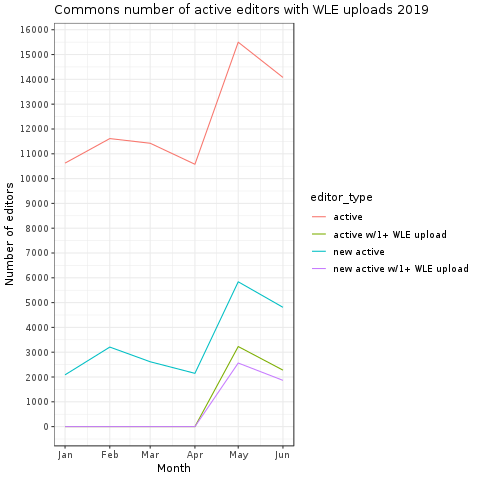

In [293]:
%%R -i commons_wle_overall_stats

commons_wle_overall_stats$log_month = as.Date(commons_wle_overall_stats$log_month)

ggplot(commons_wle_overall_stats,
       aes(x = log_month, y = n, color = editor_type)) +
theme_bw() +
scale_y_continuous("Number of editors", breaks = c(0:20)*1000) +
scale_x_date("Month") +
ggtitle("Commons number of active editors with WLE uploads 2019") +
geom_line()